In [1]:
import numpy as np
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

%matplotlib inline

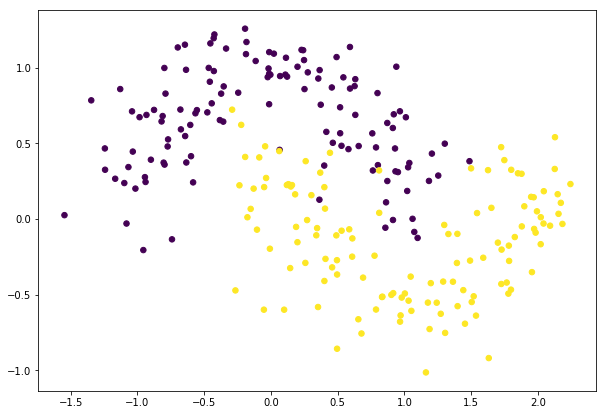

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = make_moons(250, noise=0.20)
plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], s=30, c=y)

In [3]:
# Train the logistic rgeression classifier
logreg_clf = LogisticRegressionCV()
logreg_clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [4]:
def plot_decision_boundary(predict):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .25, X[:, 0].max() + .25
    y_min, y_max = X[:, 1].min() - .25, X[:, 1].max() + .25
    h = 0.007
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral_r)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral_r)

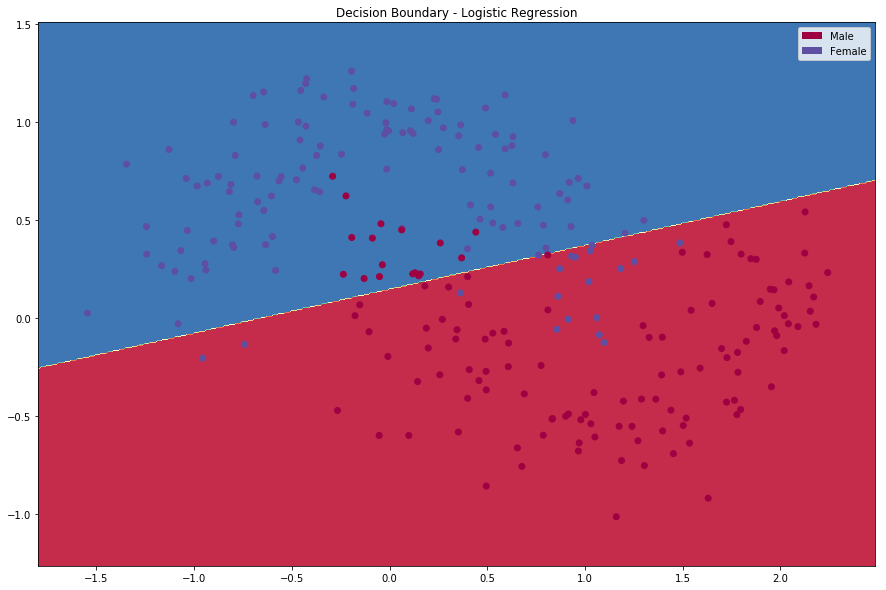

In [5]:
# Plot the decision boundary
plt.figure(figsize=(15, 10))
plot_decision_boundary(lambda x: logreg_clf.predict(x))
plt.title("Decision Boundary - Logistic Regression")

classes = ['Male','Female']
class_colours = [plt.cm.get_cmap('Spectral')(0), plt.cm.get_cmap('Spectral_r')(0)]
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
plt.legend(recs, classes, loc=1)

In [6]:
def my_tanh(array, backward=False):
    if backward:
        return (1 - np.power(array, 2))
    return np.tanh(array)

In [7]:
def my_softmax(array):
    ex = np.exp(array)
    return ex / np.sum(ex, axis=1, keepdims=True)

In [8]:
def forward_pass(model, X):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = X.dot(W1) + b1
    a1 = my_tanh(z1)
    z2 = a1.dot(W2) + b2
    return my_softmax(z2), a1

In [9]:
def calc_loss(model, X, y, reg):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    probs, _ = forward_pass(model, X)
    correct_logprobs = -np.log(probs[range(len(X)), y])
    data_loss = np.sum(correct_logprobs)
    reg_loss = reg / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    loss = data_loss + reg_loss
    return loss / len(X)

In [10]:
def predict(model, X):
    probs, _ = forward_pass(model, X)
    return np.argmax(probs, axis=1)

In [11]:
def show_legend():
    classes = ['Male','Pred male', 'Female', 'Pred female']
    class_colours = [plt.cm.get_cmap('Spectral')(0), plt.cm.get_cmap('binary_r')(0),
                     plt.cm.get_cmap('Spectral_r')(0), plt.cm.get_cmap('binary')(0)]
    recs = []
    for i in range(len(class_colours)):
        recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
    return plt.legend(recs, classes, loc=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [57]:
input_size = 2 # input layer dimensionality -> position in the plane
output_size = 2 # output layer dimensionality -> male/female

def make_model(X, y, epochs, hidden_size, decay=None, batch_size=None, print_loss=None, lr=0.02, reg=0.01):

    def get_mini_batch(X, y, n_train, batch_size):
        mask = np.random.choice(a=n_train, size=batch_size, replace=False)
        return X[mask], y[mask]
    
    if batch_size is not None:
        N = batch_size
    else:
        N = len(X) # training set size 
        
    model = {}
    model['W1'] = 1e-4 * np.random.randn(input_size, hidden_size)
    model['b1'] = np.zeros((1, hidden_size))
    model['W2'] = 1e-4 * np.random.randn(hidden_size, output_size)
    model['b2'] = np.zeros((1, output_size))
    
    for i in range(epochs):
        if batch_size is not None:
            X, y = get_mini_batch(X, y, N, batch_size)
    
        # Forward
        probs, a1 = forward_pass(model, X)

        # Backward
        delta3 = probs
        delta3[range(N), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(model['W2'].T) * my_tanh(a1, backward=True)
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (weights only)
        dW2 += reg * model['W2']
        dW1 += reg * model['W1']

        # LR decay
        if decay is not None:
            ratio, iterations = decay
            if i % iterations == 0:
                if 0 < ratio < 1:
                    lr -= lr * ratio
        
        # Gradient descent parameter update
        model['W1'] += -lr * dW1
        model['b1'] += -lr * db1
        model['W2'] += -lr * dW2
        model['b2'] += -lr * db2

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss is not None and i % print_loss == 0:
          print("Loss after iteration %i: %f" %(i, calc_loss(model, X_train, y_train, reg=reg)))
    return model

In [112]:
model = make_model(X_train, y_train, batch_size=16, lr=0.1, decay=(0.01, 100), print_loss=5000, epochs=55001, hidden_size=11)

Loss after iteration 0: 0.711742
Loss after iteration 5000: 0.313755
Loss after iteration 10000: 0.312153
Loss after iteration 15000: 0.309795
Loss after iteration 20000: 0.308333
Loss after iteration 25000: 0.307426
Loss after iteration 30000: 0.306884
Loss after iteration 35000: 0.306559
Loss after iteration 40000: 0.306364
Loss after iteration 45000: 0.306247
Loss after iteration 50000: 0.306176
Loss after iteration 55000: 0.306134


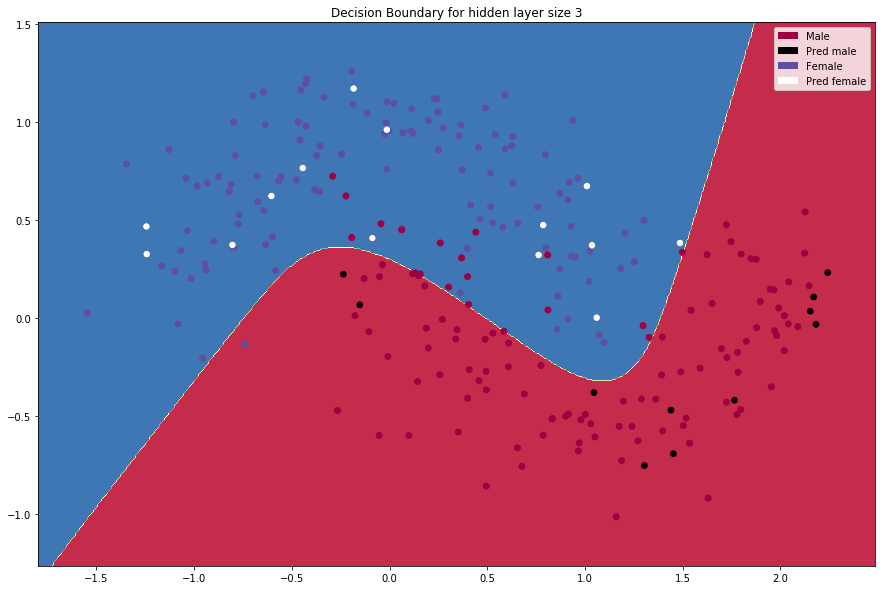

In [113]:
predictions = predict(model, X_test)
plt.figure(figsize=(15, 10))
plot_decision_boundary(lambda x: predict(model, x))
plt.scatter(X_test[:,0], X_test[:,1], s=30, c=predictions, cmap=plt.cm.binary)
plt.title("Decision Boundary for hidden layer size 3")
show_legend()

Loss after iteration 0: 0.693700
Loss after iteration 10000: 0.443853
Loss after iteration 20000: 0.445200
Loss after iteration 0: 0.693700
Loss after iteration 10000: 0.157636
Loss after iteration 20000: 0.156134
Loss after iteration 0: 0.693700
Loss after iteration 10000: 0.156613
Loss after iteration 20000: 0.154903
Loss after iteration 0: 0.693700
Loss after iteration 10000: 0.163183
Loss after iteration 20000: 0.161612
Loss after iteration 0: 0.693700
Loss after iteration 10000: 0.165084
Loss after iteration 20000: 0.162429
Loss after iteration 0: 0.693700
Loss after iteration 10000: 0.167884
Loss after iteration 20000: 0.164986


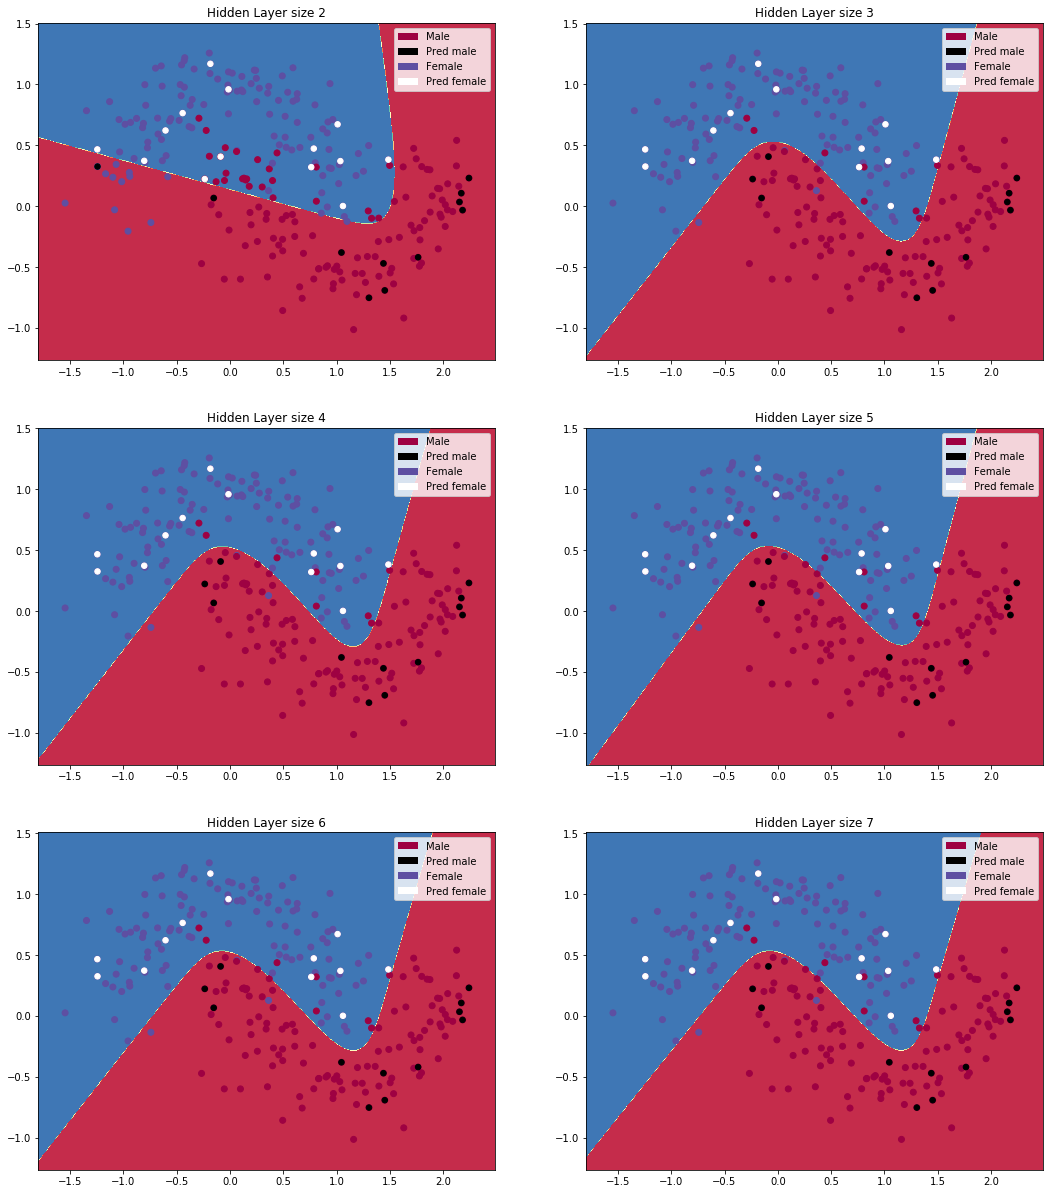

In [119]:
plt.figure(figsize=(18, 36))
hidden_sizes = [2, 3, 4, 5, 6, 7]

for i, hidden_size in enumerate(hidden_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % hidden_size)
    model = make_model(X_train, y_train, 20001, hidden_sizes[i], lr=0.02, decay=(0.05, 10000), batch_size=32, print_loss=10000)
    predictions = predict(model, X_test)
    plot_decision_boundary(lambda x: predict(model, x))
    plt.scatter(X_test[:,0], X_test[:,1], s=30, c=predictions, cmap=plt.cm.binary)
    show_legend()
plt.show()